<a href="https://colab.research.google.com/github/AmaanWanie/jupyter_notebook/blob/main/resume_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras import Sequential,layers

In [10]:
dataset_path = '/content/drive/MyDrive/resume_data'

# Define image size and batch size
image_size = (224, 224)
batch_size = 32


In [11]:
#generators
train_ds = image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,       # Split the dataset into training and validation sets
    subset='training'
)
val_ds = image_dataset_from_directory(
    directory=dataset_path,
    labels='inferred',
    label_mode='categorical',
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='validation'
)

Found 165 files belonging to 3 classes.
Using 132 files for training.
Found 165 files belonging to 3 classes.
Using 33 files for validation.


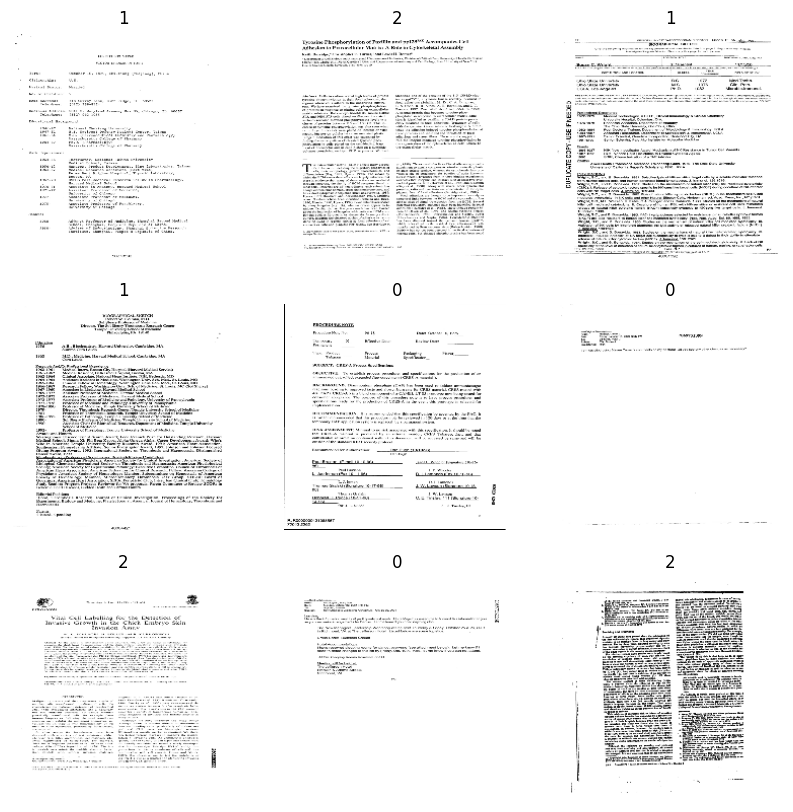

In [12]:
#visualise
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        class_index = np.argmax(labels[i])
        plt.title(class_index)
        plt.axis("off")

plt.show()


In [13]:
def process(image,label):
  tf.cast(image/255,tf.float32)
  return image,label
train_ds=train_ds.map(process)
val_ds=val_ds.map(process)

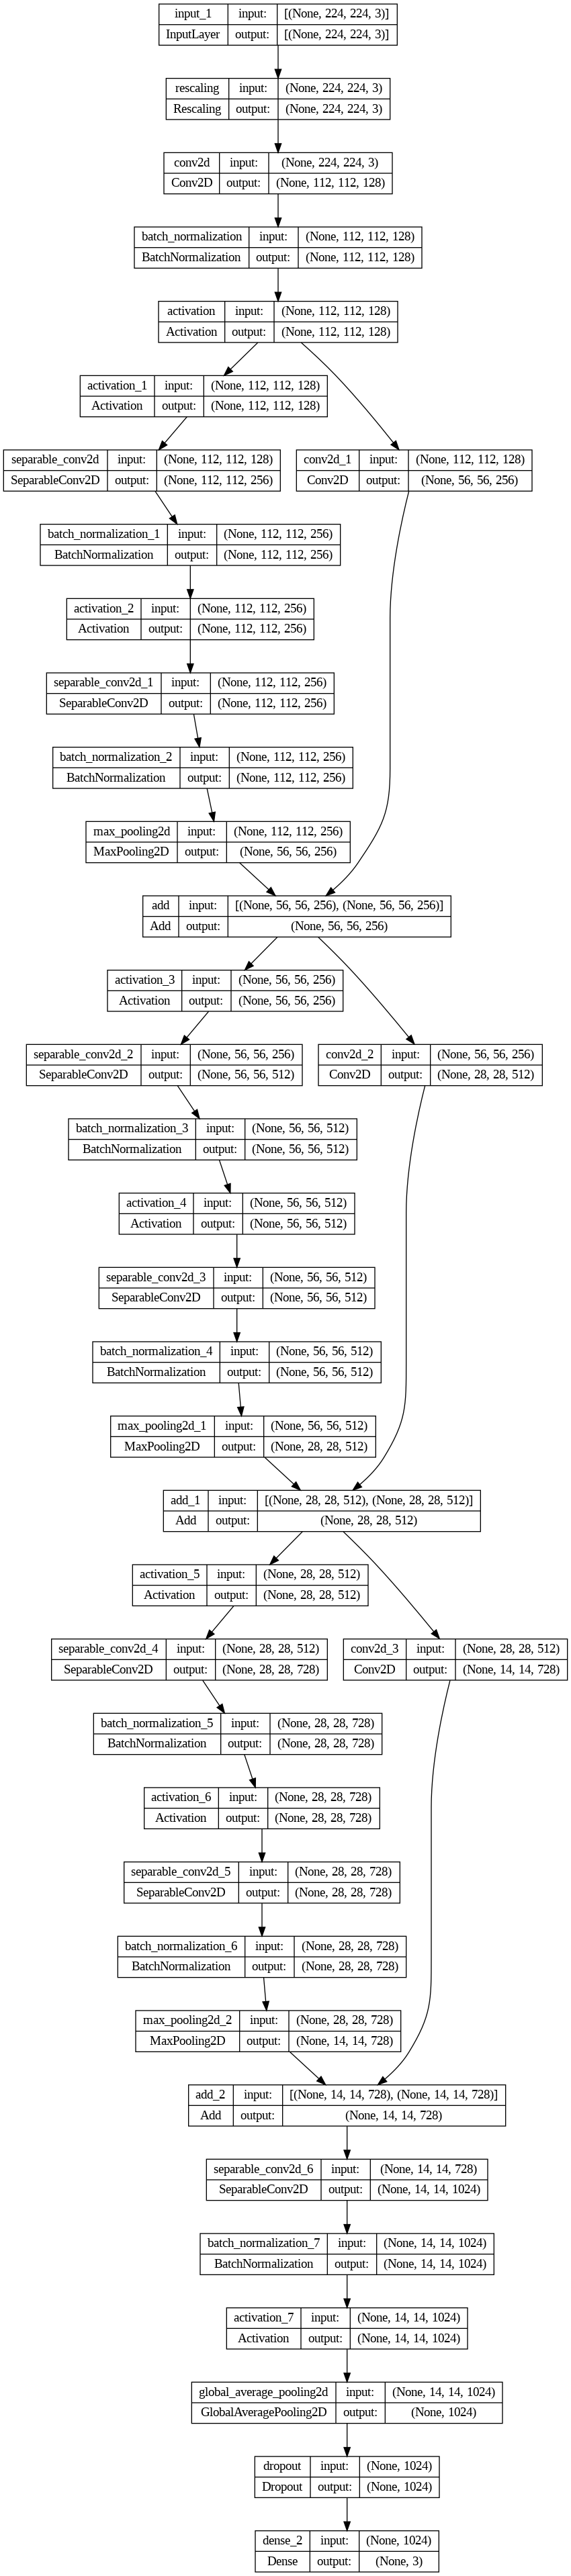

In [15]:
# Create CNN model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x)

    # Modify the final dense layer for 3 classes with softmax activation
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)

# Create the model for 3 classes
model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)


In [15]:
# Train the model
epochs = 3

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/3
5/5 [==============================] - 161s 29s/step - loss: 0.5777 - accuracy: 0.8106 - val_loss: 1.1119 - val_accuracy: 0.2727
Epoch 2/3
5/5 [==============================] - 166s 31s/step - loss: 0.4728 - accuracy: 0.8409 - val_loss: 1.1166 - val_accuracy: 0.2727
Epoch 3/3
5/5 [==============================] - 161s 31s/step - loss: 0.3583 - accuracy: 0.8561 - val_loss: 1.1209 - val_accuracy: 0.2727


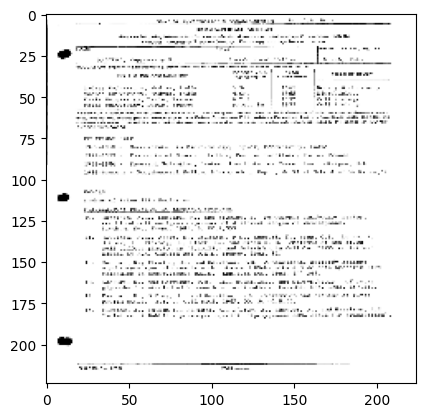

1/1 [==============================] - 2s 2s/step
Resume: 33.33%
Email: 33.33%
Scientific Journal: 33.33%


In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
# Load and display the image
img_path = "/content/drive/MyDrive/doc_000760.png"  # Replace with the path to your test image
img = image.load_img(img_path, target_size=image_size)
plt.imshow(img)
plt.show()

# Preprocess the image for prediction
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Create batch axis
img_array = img_array / 255.0  # Normalize pixel values to be between 0 and 1

# Make predictions using the simplified model
predictions = model.predict(img_array)
confidence_percentages = 100 * predictions.flatten()

# Map the predicted class to a label
class_labels = ["Resume", "Email", "Scientific Journal"]  # Replace with your actual class labels

# Display confidence percentages for each class on the screen
for label, confidence in zip(class_labels, confidence_percentages):
    print(f"{label}: {confidence:.2f}%")


In [17]:
import keras_tuner
from tensorflow import keras

def build_model(hp):
  model = keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units', [8, 16, 32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

